In [1]:
# GENERAL LIBRARIES
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import argparse
from datetime import datetime
# MACHINE LEARNING LIBRARIES
import numpy as np
import tensorflow as tf
# CUSTOM LIBRARIES
from utils.tools import read_yaml, Logger
from utils.trainer import Trainer

# LOAD CONFIG 
#parser = argparse.ArgumentParser(description='Process some input')
#parser.add_argument('--config', default='utils/config.yaml', type=str, help='Config path', required=False)    
#parser.add_argument('--infer','-i', action='store_true', help='Run inference on a model') 
#parser.add_argument('--benchmark','-b', action='store_true', help='Run a benchmark') 
#parser.add_argument('--search','-s', action='store_true', help='Run a random search')


class Args:
    def __init__(self):
        self.config = "utils/config.yaml"
        self.infer = False
        self.benchmark = False
        self.search = False
    
args = Args() #parser.parse_args()
config = read_yaml(args.config)

config['LEGACY']=False
config['DATASET']='openpose'
config['MODEL_SIZE']='micro'
config['LOAD_MODEL']='bin/AcT_micro_1_0.h5'




for entry in ['MODEL_DIR','RESULTS_DIR','LOG_DIR']:
    if not os.path.exists(config[entry]):
        os.mkdir(config[entry])

now = datetime.now()
logger = Logger(config['LOG_DIR']+now.strftime("%y%m%d%H%M%S")+'.txt')

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# SET GPU 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[config['GPU']], 'GPU')
tf.config.experimental.set_memory_growth(gpus[config['GPU']], True)


# SET TRAINER
trainer = Trainer(config, logger)

if args.benchmark:
    # RUN BENCHMARK
    trainer.do_benchmark()
elif args.infer:
    trainer.do_inference()
elif args.search:
    # RUN RANDOM SEARCH
    trainer.do_random_search()
else:
    print('Nothing to do! Specify one of the following arguments:')
    print('\t --benchmark [-b]: run a benchmark')
    print('\t --search [-s]: run a random search')

Nothing to do! Specify one of the following arguments:
	 --benchmark [-b]: run a benchmark
	 --search [-s]: run a random search


In [3]:
_,_,y,y_pred = trainer.do_inference(model='bin/AcT_micro_1_0.h5',model_size='micro')

--------------------------------------------
RUNNING INFERENCE ON bin/AcT_micro_1_0.h5
MODEL_SIZE: micro, DATASET: openpose
NOTES: New dataloader, scale-to-unit, scale_and_center, TCN embeddings
--------------------------------------------



2023-05-29 20:43:38.362977: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 141086400 exceeds 10% of free system memory.
2023-05-29 20:43:38.487792: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 141086400 exceeds 10% of free system memory.


6/6 [==============================] - 1s 27ms/step - loss: 0.9546 - accuracy: 0.8832
Accuracy Test: 0.8831531405448914 <> Balanced Accuracy: 0.8242804982752077

Generate predictions for samples
predictions shape: (2867,)


In [4]:

y_ = tf.math.argmax(tf.concat(y, axis=0), axis=1)


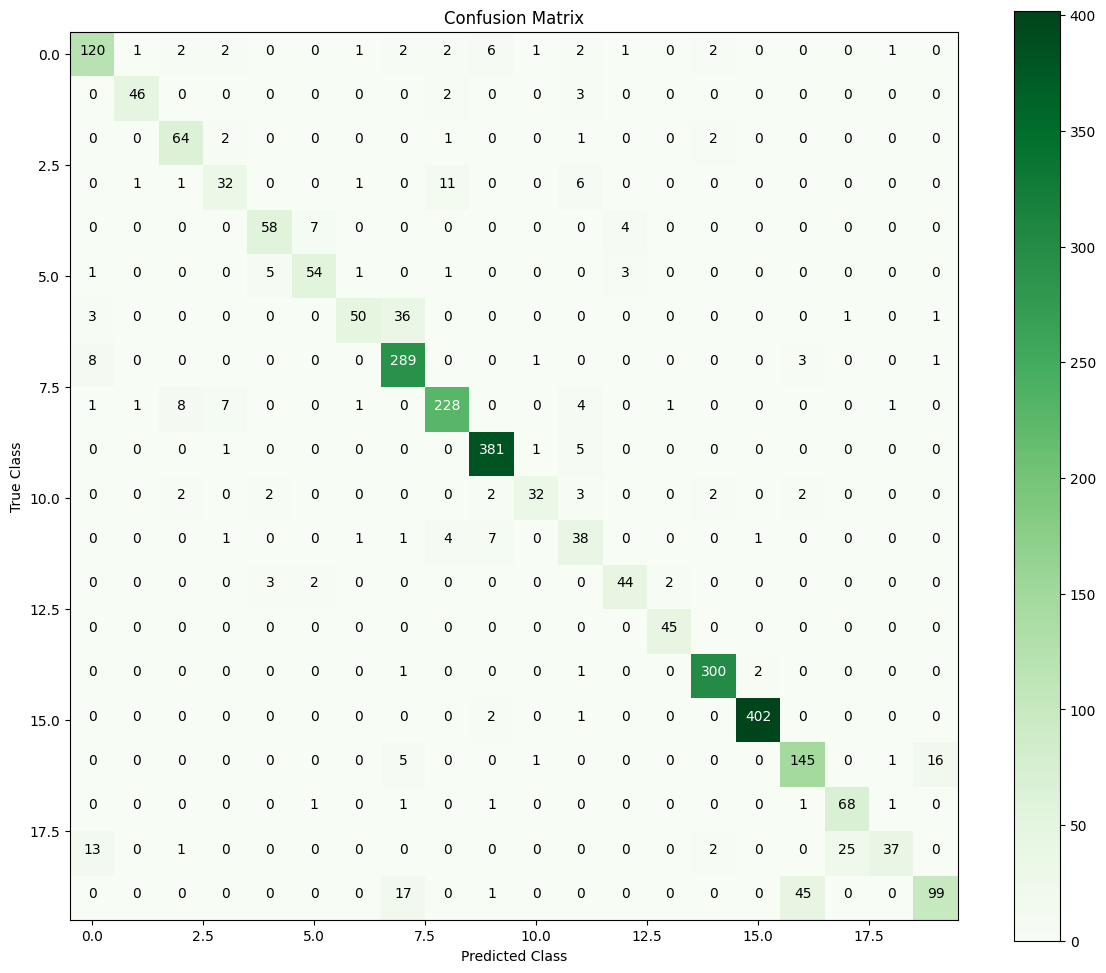

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_ and y_pred are numpy arrays
cm = confusion_matrix(y_, y_pred)

# Increase figure size
plt.figure(figsize=(12, 10))  # Adjust the width and height as desired

# Plot confusion matrix with adjusted color mapping
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)  # Adjust the colormap (e.g., plt.cm.Blues, plt.cm.Reds, etc.)

# Add labels to the matrix cells
thresh = cm.max() / 2  # Set the threshold for cell color intensity
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

# Customize the plot
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Adjust the plot layout to make labels fully visible
plt.tight_layout()

# Show the plot
plt.show()


In [5]:
from sklearn.metrics import classification_report

# Compute classification report
report = classification_report(y_, y_pred)

# Print classification report
print(report)

              precision    recall  f1-score   support

           0       0.83      0.78      0.81       143
           1       0.89      0.82      0.86        51
           2       0.78      0.84      0.81        70
           3       0.76      0.62      0.68        52
           4       0.77      0.67      0.71        69
           5       0.77      0.63      0.69        65
           6       0.89      0.55      0.68        91
           7       0.79      0.93      0.86       302
           8       0.87      0.92      0.90       252
           9       0.94      0.95      0.95       388
          10       0.78      0.78      0.78        45
          11       0.58      0.47      0.52        53
          12       0.74      0.88      0.80        51
          13       0.85      0.98      0.91        45
          14       0.97      1.00      0.99       304
          15       0.96      0.99      0.97       405
          16       0.66      0.77      0.71       168
          17       0.66    

In [21]:
from sklearn.metrics import precision_recall_curve

# Assuming y and y_pred are probability scores for binary classification
precision, recall, thresholds = precision_recall_curve(y_, y_pred)

# Plot precision-recall curve
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

ValueError: multiclass format is not supported